<a href="https://colab.research.google.com/github/purbid/topic_modeling/blob/main/bert_topic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**THIS NOTEBOOK SHOWS TOPIC MODELING USING BERTOPIC, A BERT BASED MODEL 
CREATED ESPECIALLY FOR TOPIC MODELING**



In [ ]:
import pandas as pd
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer, LancasterStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
from wordcloud import WordCloud
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
stemmer = LancasterStemmer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


INSTALL RELEVANT LIBRARIES

In [ ]:
!pip install bertopic[visualization]
!pip install bertopic

### Let's Load our data first and see a wordcloud of the titles


In [ ]:
df  = pd.read_csv("/content/drive/MyDrive/articles-data.csv")
print(df.columns)
temp_l = list(df.columns)
temp_l[0] = "article_num"
df.columns = temp_l


Index(['Unnamed: 0', 'id', 'title', 'publication', 'author', 'date', 'year',
       'month', 'url', 'content'],
      dtype='object')


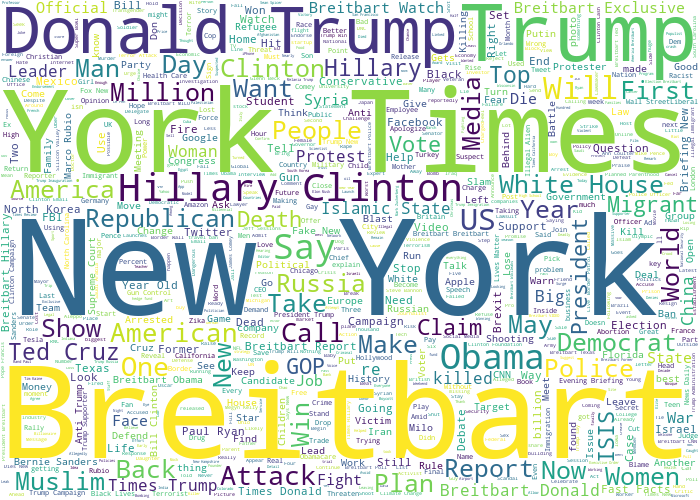

In [ ]:
long_string = ','.join(list(df['title'].values))
wordcloud = WordCloud(background_color="white", max_words=5000, width=700, height=500, contour_width=10, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

In [ ]:
'''
As we can see the headlines from the articles are from a variety of topics from 
politics to world affairs and contemporary news. The titles also have the name of 
Publishers (New York Times and Breitbart). This can be found in majority of articles 
from these publishers (we check this later), but we must remove these words, since when
we create bag-of-words/embeddings, these words will occur in vastly different articles
(An article for a tech startup and Covid will both have "The New York Times in headline").
This might create problems with differentaiting topics/articles.(Especially with BOW).


We will also truncate the article content. 2 reasons for this:
1. Most of the article content/summary in in the headline and first para.
We can infer the meaning/topic from headline+first para.

2. Smaller text means faster training for models
'''

'\nAs we can see the headlines from the articles are from a variety of topics from \npolitics to world affairs and contemporary news. The titles also have the name of \nPublishers (New York Times and Breitbart). This can be found in majority of articles \nfrom these publishers (we check this later), but we must remove these words, since when\nwe create bag-of-words/embeddings, these words will occur in vastly different articles\n(An article for a tech startup and Covid will both have "The New York Times in headline").\nThis might create problems with differentaiting topics/articles.(Especially with BOW).\n\n\nWe will also truncate the article content. 2 reasons for this:\n1. Most of the article content/summary in in the headline and first para.\nWe can infer the meaning/topic from headline+first para.\n\n2. Smaller text means faster training for models\n'

In [ ]:
'''
Let's see what all publishers are present (possibly). We see how many headings
end with these publisher names.
'''
df["last_chars_title"] = df["title"].str.replace(' ','')
df["last_chars_title"] = df.loc[:,'last_chars_title'].apply(lambda x: x[-9:])
df["last_chars_title"].value_counts().to_frame().head(20)

,last_chars_title
Breitbart,15173
YorkTimes,7806
FastFacts,262
(Opinion),121
naldTrump,89
ryClinton,52
stigation,52
hiteHouse,41
Obamacare,39
uguration,35


In [ ]:
########## as we can see there are publishers Breitbart , New York Times, Fast Facts and (Opinion). Let's remove them.
remove_headline_text = ["The New York Times", "Fast Facts", "- Breitbart", "(Opinion)"]

for i in range(len(df)):
  if i%10000==0:
    print(i)
  for word in remove_headline_text:
    if word in df.iloc[i].title:
      df.at[i, "title"] = df.iloc[i].title.replace(word,'')
  


0
10000
20000
30000
40000


In [ ]:
########### Now we concat the headline and first 50 words of the content
df["headline_content"] = df["title"] + " "+df["content"].apply(lambda x: ' '.join(x.split()[:50]))

In [ ]:
'''
train the model using bert topic.
'''
#########takes approx 40 minutes for training. 
######## Once trained, you can load the trained model for inferencing
from bertopic import BERTopic


already_trained = False

if already_trained:
  bert_model = BERTopic.load("/content/drive/MyDrive/bert_topic_model")
else:
  bert_model = BERTopic()
  topics, probabilities = bert_model.fit_transform(df.headline_content)
  ####### save the model
  # bert_model.save("/content/drive/MyDrive/bert_topic_model")

In [37]:
bert_model

In [39]:
'''
We see this is too much!  *******647********* Let's try to reduce it to something less and
then vizualise
'''

print(len(set(topics)))


############ REDUCING TO 20 TOPICS
new_topics, new_probs = bert_model.reduce_topics(df.headline_content, topics, probabilities, nr_topics=20)


640


In [40]:
##### some of the top frequencies. The top one (-1) is > 20,000, so it might be 
##### possible that these are miscellaneous topics
bert_model.get_topic_freq().head()

,Topic,Count
0,-1,19331
1,0,2821
2,1,2697
3,2,2256
4,3,2018


In [43]:
##### let's print some of the topics (0->20)
for i in range(20):
  print(bert_model.get_topic(i))
  print("****************")


####### as we can see there are some generalizations that we can infer.
###### first and second topic talks about Miscellaneous topics
##### third topic talks about border and immigration
##### Fourth topic talks about middle eastern countries
##### Last topic probably talks about US Presidnetial Elections

[('its', 0.018490089116985027), ('on', 0.018453228453706956), ('is', 0.01835213498302439), ('breitbart', 0.01833154291155906), ('facebook', 0.014579632129493649), ('has', 0.013504200425829282), ('apple', 0.013008618541420214), ('tesla', 0.012767163596234109), ('will', 0.012577648714340013), ('company', 0.011232444812261636)]
****************
[('his', 0.024242602462054695), ('trump', 0.022004169547099765), ('he', 0.018117158348464786), ('donald', 0.017848884931689034), ('ryan', 0.014376104450196107), ('bannon', 0.014190282305763594), ('president', 0.01357284227312727), ('trumps', 0.013156557124218168), ('cnn', 0.011427761109509627), ('who', 0.010508248209461233)]
****************
[('border', 0.026630636445992492), ('immigration', 0.019424861402315752), ('illegal', 0.017646397811127677), ('mexican', 0.017461013982317152), ('mexico', 0.015064879397716361), ('president', 0.014492648815601169), ('trump', 0.013734065175891024), ('donald', 0.010761885618232858), ('immigrants', 0.0100820925999

In [47]:
bert_model.get_topic_info()

,Topic,Count,Name
0,-1,19331,-1_trump_with_donald_his
1,0,2821,0_its_on_is_breitbart
2,1,2697,1_his_trump_he_donald
3,2,2256,2_border_immigration_illegal_mexican
4,3,2018,3_islamic_korea_isis_israel
5,4,1869,4_sanders_clinton_bernie_presidential
6,5,1859,5_russia_russian_putin_syria
7,6,1791,6_police_gun_shooting_shot
8,7,1782,7_sessions_jeff_kaepernick_trump
9,8,1614,8_her_she_cnn_abortion


In [45]:

'''
Now to vizualise the model. Overlapping means the topic are still not 
totally segregated. Ideal results show non overlapping (mostly) circles.
that are spaced out
'''
bert_model.visualize_topics()

In [ ]:
######## as we can see there is some scope for reducing the topics,
######## Even though they seem like largely overlapping circles, if we zoom in, these circles are spaced out.
######## On seeing the top words, we can see the close circles (bubbles) also are different topics,
######## hence it makes sense for them to be separate.

 

top 10 words from each topic (0 indexed topics)





**TOPIC 0: MISC**


WORDS:[('its', 0.018490089116985027), ('on', 0.018453228453706956), ('is', 0.01835213498302439), ('breitbart', 0.01833154291155906), ('facebook', 0.014579632129493649), ('has', 0.013504200425829282), ('apple', 0.013008618541420214), ('tesla', 0.012767163596234109), ('will', 0.012577648714340013), ('company', 0.011232444812261636)]


**TOPIC 1: MISC**

WORDS: [('his', 0.024242602462054695), ('trump', 0.022004169547099765), ('he', 0.018117158348464786), ('donald', 0.017848884931689034), ('ryan', 0.014376104450196107), ('bannon', 0.014190282305763594), ('president', 0.01357284227312727), ('trumps', 0.013156557124218168), ('cnn', 0.011427761109509627), ('who', 0.010508248209461233)]


**TOPIC 2: Immigration**

WORDS: [('border', 0.026630636445992492), ('immigration', 0.019424861402315752), ('illegal', 0.017646397811127677), ('mexican', 0.017461013982317152), ('mexico', 0.015064879397716361), ('president', 0.014492648815601169), ('trump', 0.013734065175891024), ('donald', 0.010761885618232858), ('immigrants', 0.010082092599972572), ('cuban', 0.009967591778704515)]


**TOPIC 3: Middle East**

WORDS: [('islamic', 0.01813009848216051), ('korea', 0.0166789185167139), ('isis', 0.01653163902102029), ('israel', 0.014759788092298021), ('saudi', 0.013713435620264135), ('president', 0.01306305160613022), ('cnn', 0.013030387433906625), ('muslim', 0.012925559910612765), ('jerusalem', 0.011256305689405478), ('us', 0.01112333959759508)]


**TOPIC 4: US Presedential Elections**

WORDS: [('sanders', 0.03613734033819234), ('clinton', 0.035070688021866296), ('bernie', 0.027387617228452815), ('presidential', 0.025087030475172793), ('democratic', 0.023222977703447716), ('debate', 0.022928216634158796), ('republican', 0.015884235127772456), ('democrats', 0.01323699880209667), ('election', 0.013165670752725622), ('voters', 0.01193267543047747)]

**TOPIC 5: International Politics**

WORDS: [('russia', 0.027310701048109183), ('russian', 0.025902541603751827), ('putin', 0.01719788226007346), ('syria', 0.016704125985795445), ('cnn', 0.014226334053379721), ('syrian', 0.013631117071402419), ('turkey', 0.013355959391233019), ('trump', 0.011508947088457188), ('turkish', 0.010594127242367139), ('aleppo', 0.010569929814943486)]

**TOPIC 6: Crime and Law-Enforcement**

WORDS: [('police', 0.04085881614016169), ('gun', 0.03668233366365341), ('shooting', 0.023901066827754013), ('shot', 0.018043259889794275), ('officers', 0.0176221434322545), ('officer', 0.01713134469672854), ('cnn', 0.013358856113510242), ('killed', 0.012699154990590333), ('guns', 0.012479751933984533), ('suspect', 0.011079720622919646)]


**TOPIC 7: Sports and Activism**

WORDS:[('sessions', 0.02570804261666441), ('jeff', 0.016398992218763175), ('kaepernick', 0.012497969691773315), ('trump', 0.012064363160626321), ('nfl', 0.011379265824514232), ('colin', 0.010885342170628158), ('clinton', 0.010737053181468208), ('donald', 0.010684123908486486), ('attorney', 0.010464654118805058), ('quarterback', 0.009929919182961038)]


**TOPIC 8: Gender and Parenthood**

WORDS: [('her', 0.02639120029911507), ('she', 0.01723422329792779), ('cnn', 0.015164444532123648), ('abortion', 0.01395740394338891), ('birth', 0.013593803817468294), ('parenthood', 0.013507872585240525), ('women', 0.013126841287650317), ('mother', 0.011307117463872333), ('trump', 0.009887857764705825), ('transgender', 0.009805134119209571)]


**TOPIC 9: Brexit**

WORDS: [('european', 0.024049378056266953), ('brexit', 0.020352418198271004), ('migrants', 0.018774357303465515), ('eu', 0.018091738047107335), ('german', 0.014889394513296999), ('migrant', 0.014232997847361189), ('britain', 0.013647851388146557), ('french', 0.012730634215196391), ('europe', 0.012008889494210917), ('germany', 0.011695136954744357)]


**TOPIC 10: News Leaks and Scandals**

WORDS: [('comey', 0.042914217312011144), ('fbi', 0.04016086741693937), ('hillary', 0.032733122761776486), ('clinton', 0.03207147382886478), ('email', 0.030908938608658874), ('emails', 0.01929735156750342), ('clintons', 0.018593617890219502), ('server', 0.017713950518552825), ('president', 0.016527765000431967), ('wikileaks', 0.015624087881057187)]


**TOPIC 11: Education**

WORDS: [('milo', 0.05324153211616968), ('university', 0.028266823279036225), ('yiannopoulos', 0.023682378842834393), ('breitbart', 0.01987329910893271), ('megyn', 0.019006296631131837), ('campus', 0.015041086691120234), ('coulter', 0.014520401293732757), ('college', 0.014019248623740451), ('berkeley', 0.013652519116871232), ('uc', 0.0121694077540594)]

**TOPIC 12: HealthCare Laws / HeathCare**

WORDS: [('obamacare', 0.04587420465286928), ('care', 0.03832898648148771), ('bill', 0.02500033076604934), ('repeal', 0.0238534078153333), ('tax', 0.02138711391927789), ('republicans', 0.017518096067950364), ('healthcare', 0.014473390208193198), ('marijuana', 0.014361475442913595), ('insurance', 0.013544547761795969), ('gop', 0.011839781186304408)]


**TOPIC 13: Climate Change**

WORDS: [('china', 0.03471482698191067), ('climate', 0.022951303972347577), ('cnn', 0.015759918505522972), ('chinese', 0.014851116856574167), ('storm', 0.012903921342923666), ('hurricane', 0.01251650049461837), ('its', 0.012273049584148541), ('sea', 0.01100179279433182), ('chinas', 0.010372359542182776), ('south', 0.009985616944815843)]



**TOPIC 14: MISC**

WORDS:[('zika', 0.029379649164748497), ('black', 0.028978312875078), ('trump', 0.021987833213297635), ('clinton', 0.02095714749076497), ('hillary', 0.01890565964320516), ('donald', 0.018636379303054087), ('matter', 0.018214865266771536), ('virus', 0.01718845105531097), ('cnn', 0.011500312359126413), ('her', 0.010100381629684834)]



**TOPIC 15: MISC**

WORDS: [('sanctuary', 0.016317896760091915), ('trump', 0.014976529013227127), ('jobs', 0.014013558807322959), ('golf', 0.013853306338322473), ('trade', 0.012230324617288848), ('he', 0.012183735426528744), ('pipeline', 0.010800467147803664), ('woods', 0.010734126415067834), ('dakota', 0.010633203927653502), ('cities', 0.010531285704962152)]



**TOPIC 16: Transportation**

WORDS: [('uber', 0.030384424629680596), ('flight', 0.024558398575689058), ('plane', 0.016629473426531826), ('car', 0.016398206799439707), ('cnn', 0.014857122439903577), ('airlines', 0.014587457747600853), ('cars', 0.013521798063994984), ('company', 0.01335569099462626), ('nasa', 0.012617278494933295), ('crash', 0.012169618257595485)]


**TOPIC 17: Judiciary**

WORDS:[('court', 0.044151085217798335), ('supreme', 0.03692570162000702), ('gorsuch', 0.027962997811333525), ('justice', 0.022555479176433517), ('judge', 0.021485388578897025), ('scalia', 0.01978149225317087), ('president', 0.016312799626562458), ('senate', 0.014109612252054267), ('trump', 0.011959608731863127), ('washington', 0.011762160575670515)]


**TOPIC 19: US Presedential Elections**

WORDS: [('rio', 0.03147471869537271), ('obama', 0.023954465933043578), ('olympic', 0.020641472753588373), ('president', 0.020593644854219818), ('trump', 0.018589734778469702), ('olympics', 0.01747840206200141), ('donald', 0.015367967017981739), ('janeiro', 0.012618335512955813), ('inauguration', 0.012178601270814942), ('barack', 0.011714690555538325)]



In [48]:
'''
Note : As we can see, some topics are miscellaneous and some are overlapping/
repeating. We can try reducing the num_topics to 15-17 and reduce num topics, 
while preserving the generalisation. 

'''


'\nNote : As we can see, some topics are miscellaneous and some are overlapping/\nrepeating. We can try reducing the num_topics to 15-17 and reduce num topics, \nwhile preserving the generalisation. \n\n'